In [16]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import echopype as ep
from sklearn.cluster import KMeans

In [2]:
fname = './data/GLIDER_SB_2018_v5-Phase0-D20180625-T104250-2.nc'
ed = ep.open_converted(fname)
ds = ep.calibrate.compute_Sv(ed, waveform_mode='BB', encode_mode='complex')
ds

<xarray.Dataset>
Dimensions:                (ping_time: 96, frequency: 1, range_bin: 25296)
Coordinates:
  * ping_time              (ping_time) datetime64[ns] 2018-06-25T10:42:50.967...
  * frequency              (frequency) float64 3.33e+05
  * range_bin              (range_bin) int32 0 1 2 3 ... 25292 25293 25294 25295
Data variables:
    Sv                     (frequency, ping_time, range_bin) float64 nan ... ...
    range                  (frequency, ping_time, range_bin) float64 0.0 ... ...
    temperature            (ping_time) float64 8.0 nan nan nan ... nan nan nan
    salinity               (ping_time) float64 35.0 nan nan nan ... nan nan nan
    pressure               (ping_time) float64 5.0 nan nan nan ... nan nan nan
    sound_speed            (ping_time) float64 1.482e+03 nan nan ... nan nan nan
    sound_absorption       (ping_time, frequency) float64 0.08015 nan ... nan
    sa_correction          object None
    gain_correction        object None
    equivalent_beam_angle  (frequency) float64 ...

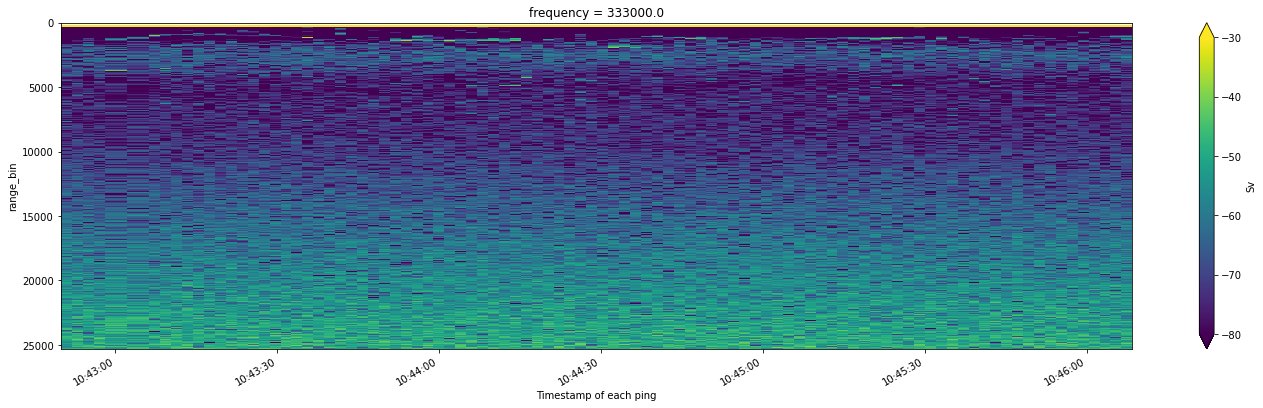

In [3]:
fig = (ds.Sv).plot(x='ping_time', size=6, aspect=4, cmap="viridis", vmin=-80, vmax=-30)
plt.gca().invert_yaxis()

# slice depth

In [4]:
ds = ds.isel(frequency=0,range_bin=slice(300,10000))
ds

<xarray.Dataset>
Dimensions:                (ping_time: 96, range_bin: 9700)
Coordinates:
  * ping_time              (ping_time) datetime64[ns] 2018-06-25T10:42:50.967...
    frequency              float64 3.33e+05
  * range_bin              (range_bin) int32 300 301 302 303 ... 9997 9998 9999
Data variables:
    Sv                     (ping_time, range_bin) float64 -15.82 ... -75.12
    range                  (ping_time, range_bin) float64 1.02 1.026 ... 58.53
    temperature            (ping_time) float64 8.0 nan nan nan ... nan nan nan
    salinity               (ping_time) float64 35.0 nan nan nan ... nan nan nan
    pressure               (ping_time) float64 5.0 nan nan nan ... nan nan nan
    sound_speed            (ping_time) float64 1.482e+03 nan nan ... nan nan nan
    sound_absorption       (ping_time) float64 0.08015 nan nan ... nan nan nan
    sa_correction          object None
    gain_correction        object None
    equivalent_beam_angle  float64 -21.0

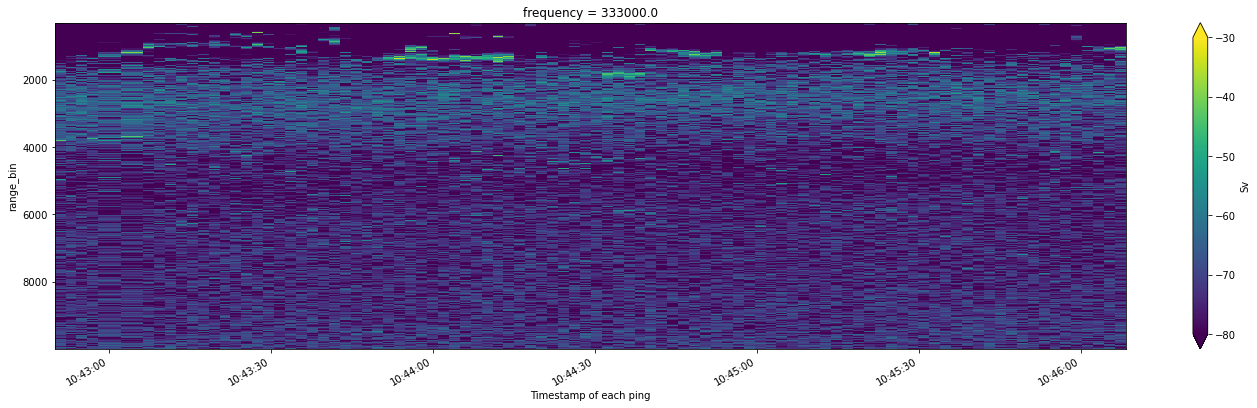

In [5]:
fig = (ds.Sv).plot(x='ping_time', size=6, aspect=4, cmap="viridis", vmin=-80, vmax=-30)
plt.gca().invert_yaxis()

window depth=194
window time=19
time min init: 2018-06-25T10:42:50.967000064, max: 2018-06-25T10:46:07.398000128
len time: 96
time min smooth: 2018-06-25T10:42:50.967000064, max: 2018-06-25T10:46:07.398000128
len time smooth: 96


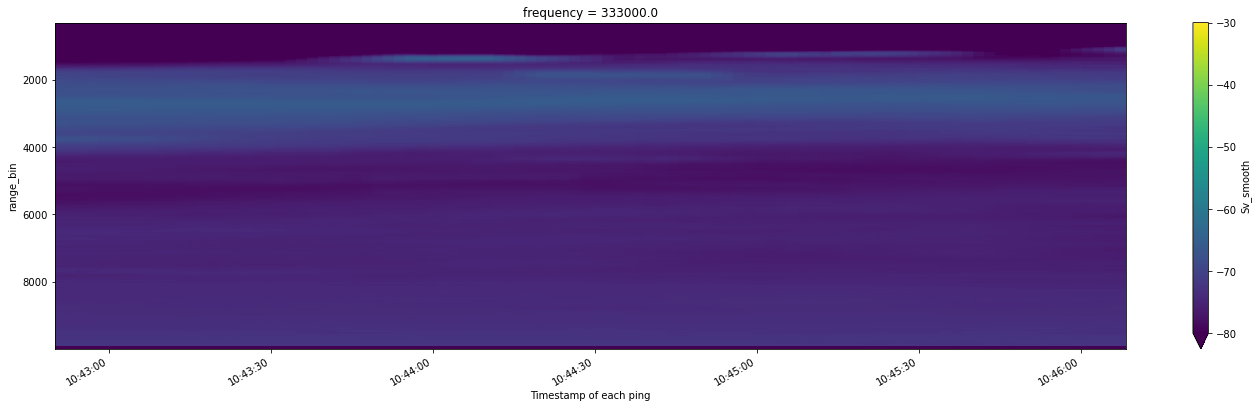

In [7]:
ds_s = ds[['Sv']]

time_smoothing = max(len(ds_s['ping_time'].data)//5, 1)
depth_smoothing = len(ds_s['range_bin'].data)//50
print(f'window depth={depth_smoothing}')
print(f'window time={time_smoothing}')
print(f"time min init: {ds_s['ping_time'].min().data}, max: {ds_s['ping_time'].max().data}")
print(f"len time: {len(ds_s['ping_time'])}")

# smoothing on time axis
Sv_smooth = ds_s['Sv'].pad(ping_time=(time_smoothing, time_smoothing), mode='edge').rolling(ping_time=time_smoothing, center=True).mean()
Sv_smooth = Sv_smooth.isel(ping_time=np.arange(time_smoothing, len(ds_s['ping_time'])+time_smoothing))

# smoothing on depth axis
Sv_smooth = Sv_smooth.pad(range_bin=(depth_smoothing, depth_smoothing), mode='constant', constant_values=ds_s['Sv'].min()).rolling(range_bin=depth_smoothing, center=True).mean()
Sv_smooth = Sv_smooth.isel(range_bin=np.arange(depth_smoothing, len(ds_s['range_bin'])+depth_smoothing))

print(f"time min smooth: {Sv_smooth['ping_time'].min().data}, max: {Sv_smooth['ping_time'].max().data}")
print(f"len time smooth: {len(Sv_smooth['ping_time'])}")

ds_s = ds_s.assign(variables={"Sv_smooth": (('ping_time', 'range_bin'), Sv_smooth.data)})
ds_s.Sv_smooth.plot(x='ping_time', size=6, aspect=4, cmap="viridis", vmin=-80, vmax=-30)
plt.gca().invert_yaxis()

In [56]:
ds_a = ds_s
# ds_a = ds_s[['Sv_smooth']].dropna('ping_time', how='all')
# ds_a = ds_a.dropna('range_bin', how='all')
# ds_a = ds_a.interpolate_na('range_bin', method="linear")
# ds_a = ds_a.dropna('range_bin', how='any')
# ds_a

In [57]:
stacked = ds_a.stack(z=('ping_time', 'range_bin'))
stacked

<xarray.Dataset>
Dimensions:    (z: 931200)
Coordinates:
    frequency  float64 3.33e+05
  * z          (z) MultiIndex
  - ping_time  (z) datetime64[ns] 2018-06-25T10:42:50.967000064 ... 2018-06-2...
  - range_bin  (z) int64 300 301 302 303 304 305 ... 9995 9996 9997 9998 9999
Data variables:
    Sv         (z) float64 -15.82 -24.66 -19.43 -22.53 ... -66.78 -72.64 -75.12
    Sv_smooth  (z) float64 -113.4 -113.1 -112.8 -112.5 ... -108.9 -109.2 -109.6
    Sv_mask    (z) bool False False False False ... False False False False

# Apply Kmeans

In [81]:
N_CLUSTERS = 5

X = stacked['Sv_smooth'].data.reshape(-1, 1)
kmeans = KMeans(n_clusters=N_CLUSTERS)
y = kmeans.fit_predict(X)
y

array([3, 3, 3, ..., 3, 3, 3], dtype=int32)

In [82]:
stacked = stacked.assign(variables={"clusters": (('z'), y)})
stacked

<xarray.Dataset>
Dimensions:    (z: 931200)
Coordinates:
    frequency  float64 3.33e+05
  * z          (z) MultiIndex
  - ping_time  (z) datetime64[ns] 2018-06-25T10:42:50.967000064 ... 2018-06-2...
  - range_bin  (z) int64 300 301 302 303 304 305 ... 9995 9996 9997 9998 9999
Data variables:
    Sv         (z) float64 -15.82 -24.66 -19.43 -22.53 ... -66.78 -72.64 -75.12
    Sv_smooth  (z) float64 -113.4 -113.1 -112.8 -112.5 ... -108.9 -109.2 -109.6
    Sv_mask    (z) bool False False False False ... False False False False
    clusters   (z) int32 3 3 3 3 3 3 3 3 3 3 3 3 3 ... 3 3 3 3 3 3 3 3 3 3 3 3 3

In [83]:
res = stacked.unstack('z')
res

<xarray.Dataset>
Dimensions:    (ping_time: 96, range_bin: 9700)
Coordinates:
    frequency  float64 3.33e+05
  * ping_time  (ping_time) datetime64[ns] 2018-06-25T10:42:50.967000064 ... 2...
  * range_bin  (range_bin) int64 300 301 302 303 304 ... 9996 9997 9998 9999
Data variables:
    Sv         (ping_time, range_bin) float64 -15.82 -24.66 ... -72.64 -75.12
    Sv_smooth  (ping_time, range_bin) float64 -113.4 -113.1 ... -109.2 -109.6
    Sv_mask    (ping_time, range_bin) bool False False False ... False False
    clusters   (ping_time, range_bin) int32 3 3 3 3 3 3 3 3 ... 3 3 3 3 3 3 3 3

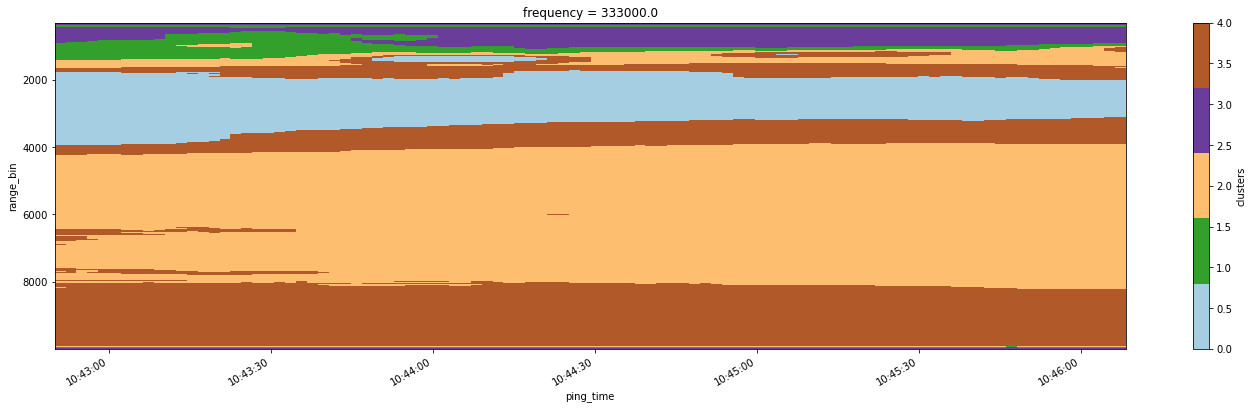

In [84]:
fig = res['clusters'].plot(x='ping_time', size=6, aspect=4, cmap=plt.cm.get_cmap('Paired', N_CLUSTERS)).figure
plt.gca().invert_yaxis()

In [55]:
fig.savefig('kmean.png')

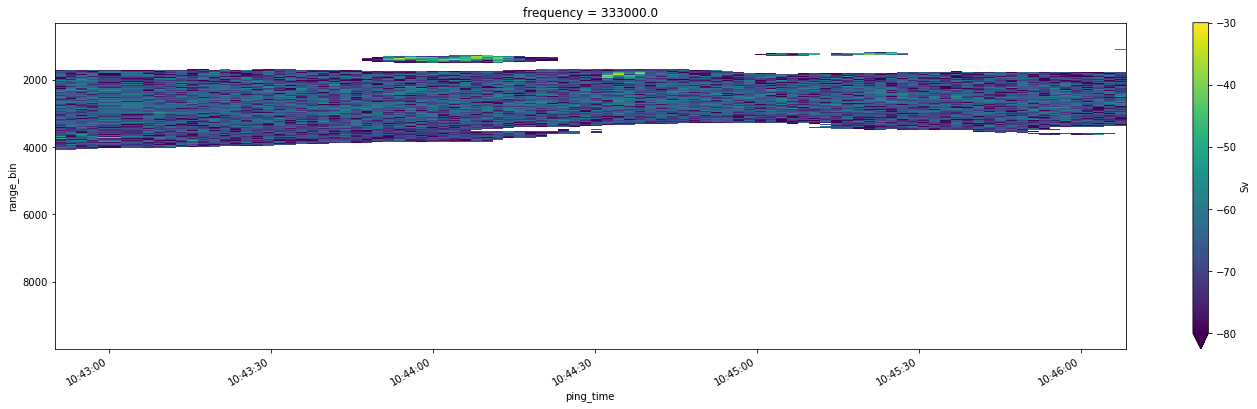

In [64]:
fig = res['Sv'].where(res['clusters']==2).plot(x='ping_time', size=6, aspect=4, cmap="viridis", vmin=-80, vmax=-30)
plt.gca().invert_yaxis()

In [66]:
fig.figure.savefig('kmean_applied.png')

In [76]:
top_layer = res['range_bin'].where(res['clusters']==2).min(dim='range_bin')
bottom_layer = res['range_bin'].where(res['clusters']==2).max(dim='range_bin')

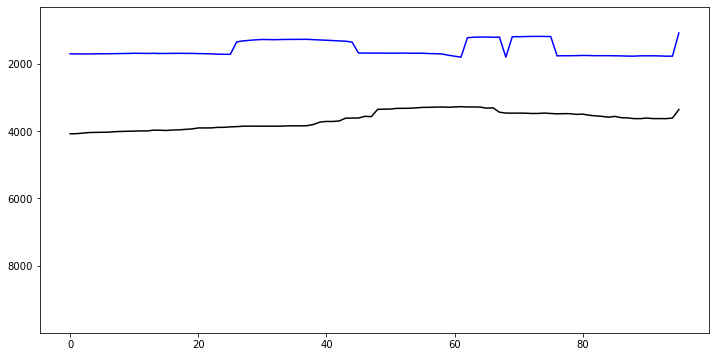

In [80]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(top_layer.data, color='blue', label='Sine wave')
ax.plot(bottom_layer.data, color='black', label='Cosine wave')

plt.ylim([300, 9999])
plt.gca().invert_yaxis()
fig.figure.savefig('kmean_depth_layer.png')

In [ ]:
for kernel in ('linear', 'poly', 'rbf'):
    clf = svm.SVC(kernel=kernel, gamma=2)
    clf.fit(X, Y)

    # plot the line, the points, and the nearest vectors to the plane
    plt.figure(fignum, figsize=(4, 3))
    plt.clf()

    plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=80,
                facecolors='none', zorder=10, edgecolors='k')
    plt.scatter(X[:, 0], X[:, 1], c=Y, zorder=10, cmap=plt.cm.Paired,
                edgecolors='k')

    plt.axis('tight')
    x_min = -3
    x_max = 3
    y_min = -3
    y_max = 3

    XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
    Z = clf.decision_function(np.c_[XX.ravel(), YY.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(XX.shape)
    plt.figure(fignum, figsize=(4, 3))
    plt.pcolormesh(XX, YY, Z > 0, cmap=plt.cm.Paired)
    plt.contour(XX, YY, Z, colors=['k', 'k', 'k'], linestyles=['--', '-', '--'],
                levels=[-.5, 0, .5])

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

    plt.xticks(())
    plt.yticks(())
    fignum = fignum + 1
plt.show()

In [15]:
from sklearn.cluster import MeanShift, estimate_bandwidth

sv = ds_s['Sv_smooth'].dropna('ping_time', how='all')
sv = sv.dropna('range_bin', how='all')
sv = sv.interpolate_na('range_bin', method="linear")
sv = sv.dropna('range_bin', how='any')

bandwidth = estimate_bandwidth(sv.data, quantile=0.2, n_samples=500)
bandwidth

281.89381518583974

In [17]:
X = sv.data

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

print("number of estimated clusters : %d" % n_clusters_)

/export/home/lbachelo/anaconda3/envs/bioacoustics/lib/python3.9/site-packages/sklearn/cluster/_mean_shift.py:236: UserWarning: Binning data failed with provided bin_size=1.028507, using data points as seeds.
  warnings.warn("Binning data failed with provided bin_size=%f,"


number of estimated clusters : 92


number of estimated clusters : 3


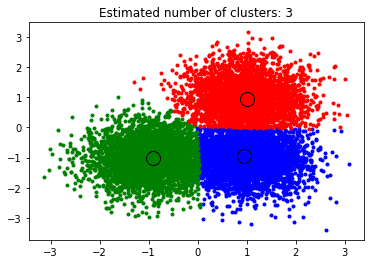

In [16]:
import numpy as np
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.datasets import make_blobs

# #############################################################################
# Generate sample data
centers = [[1, 1], [-1, -1], [1, -1]]
X, _ = make_blobs(n_samples=10000, centers=centers, cluster_std=0.6)

# #############################################################################
# Compute clustering with MeanShift

# The following bandwidth can be automatically detected using
bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=500)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

print("number of estimated clusters : %d" % n_clusters_)

# #############################################################################
# Plot result
import matplotlib.pyplot as plt
from itertools import cycle

plt.figure(1)
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    cluster_center = cluster_centers[k]
    plt.plot(X[my_members, 0], X[my_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()